## Two-Body Orbital Propagator
This project impliments a numerical orbital propagator from scratch in Python, simulating satellite motion around Earth using the basic two body gravity model.

### Physics
I start from Newtonian gravity:

a = -GM/R^3 * r

where GM is Earth's gravitational parameter (3.986 x 10^14 m^3/s^2) and r is the position vector from Earth's center. I integrate this forward in time with scipy's RK45 ODE solver, a fourth/fifth order Runge-Kutta method with adaptive step size control.

### What it does
- Propagates a satellite state vector [x, y, z, vx, vy, vz] through one full orbital period
- Computes classical orbital elements (semi-major axis, eccentricity, inclination) from the Cartesian state using the vis-viva equation and angular momentum vector
- Plots circular and elliptical orbits in 3D
- Validates accuracy by confirming zero radius drift over a full orbit

Validataion
For a circular orbit at 400km altitude, the propagator returns an orbital period of 92.39 minutes, consistent with the ISS (~92.5 minutes). Over one full orbit, the radius variation is essentially zero within numerical precision.

In [9]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#Constants
GM = 3.986004418e14 #Earth's gravitational parameter, m^3/s^2
R_earth = 6.37e6    #Earth's radius in meters

def equations_of_motion(t, state):
    """
    state = [x, y, z, vw, vy, vz]
    returns derivatives = [vx, vy, vz, ax, ay, az]
    """

    x, y, z, vx, vy, vz = state
    
    r = np.sqrt(x**2 + y**2 +z**2)     #distance from Earth's center

    #acceleration components from a = -GM/r^2 * r_hat
    ax = -GM * x /r**3
    ay = -GM * y /r**3
    az = -GM * z /r**3

    return[vx, vy, vz, ax, ay, az]


In [10]:
#Initial conditions for a circular orbit at 400km altitude
altitude = 400e3    #400 km in meters
r0 = R_earth + altitude     #distance from Earth's center

#Circular orbit velocity: V = sqrt(GM/r)
v_circ = np.sqrt(GM / r0)   #setting gravitational force= centripetal force

# Start at (r0, 0, 0) moving in the y direction for a circular orbit
state0 = [r0, 0, 0, 0, v_circ, 0]

# Time span - one orbital period
T = 2 * np.pi * np.sqrt(r0**3 / GM)     #Kepler's third law
print (f"Orbital period: {T/60: .2f} minutes")

t_span = (0, T)
t_eval = np.linspace(0, T, 1000)    # 1000 points to evaluate at


Orbital period:  92.39 minutes


In [11]:
#Run the integrator
solution = solve_ivp(
    equations_of_motion,
    t_span, 
    state0,
    t_eval=t_eval,
    method="RK45",
    rtol=1e-10,
    atol=1e-12
)

print(f"Integration successful: {solution.success}")
print(f"Solution shape: {solution.y.shape}")

Integration successful: True
Solution shape: (6, 1000)


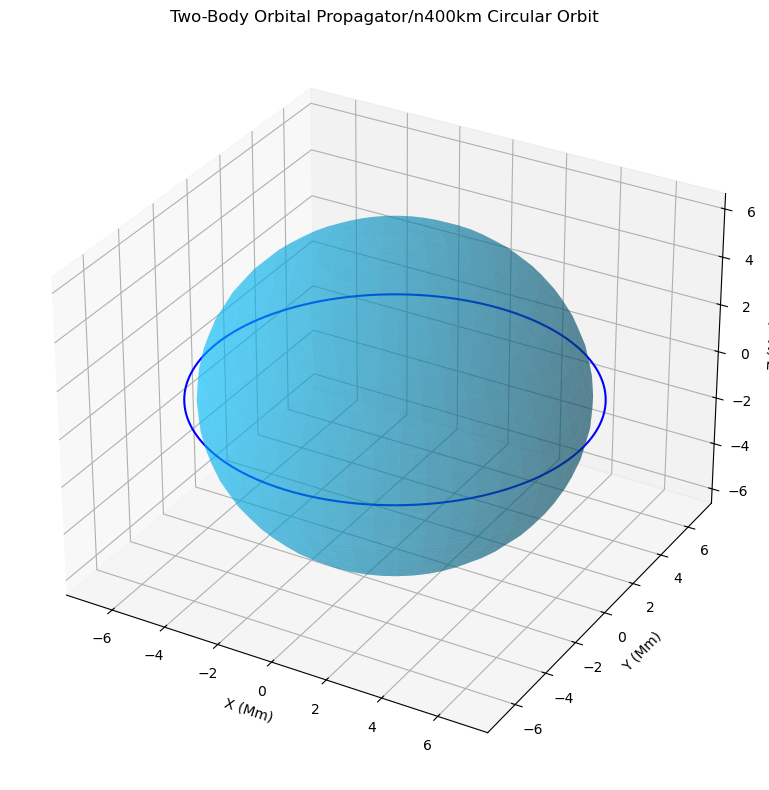

In [17]:
# Extract position components
x = solution.y[0]
y = solution.y[1]
z = solution.y[2]

# 3D orbit plot
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection = '3d')

# Plot orbit
ax.plot(x/1e6, y/1e6, z/1e6, 'b-', linewidth=1.5, label='Orbit')

# Draw Earth as a sphere
u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:25j]
ex = (R_earth/1e6) * np.cos(u) * np.sin(v)
ey = (R_earth/1e6) * np.sin(u) * np.sin(v)
ez = (R_earth/1e6) * np.cos(v)
ax.plot_surface(ex, ey, ez, color = "deepskyblue", alpha = 0.4)

# Formatting
ax.set_xlabel('X (Mm)')
ax.set_ylabel('Y (Mm)')
ax.set_zlabel('Z (Mm)')
ax.set_title('Two-Body Orbital Propagator/n400km Circular Orbit')

plt.tight_layout()
plt.show()



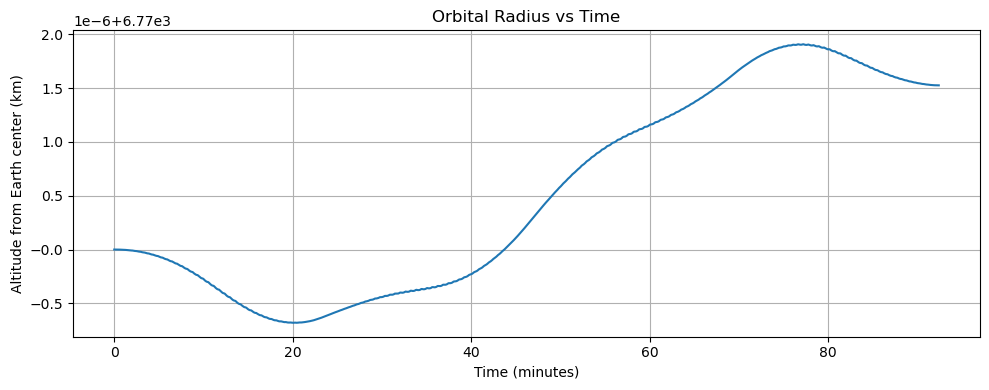

Max radius variation: 0.00 meters


In [18]:
# Check that the orbit stays circular by plotting the radius over time
r = np.sqrt(x**2 + y**2 + z**2)

plt.figure(figsize=(10,4))
plt.plot(solution.t/60, r/1e3)
plt.xlabel('Time (minutes)')
plt.ylabel('Altitude from Earth center (km)')
plt.title('Orbital Radius vs Time')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Max radius variation: {(r.max() - r.min()):.2f} meters")

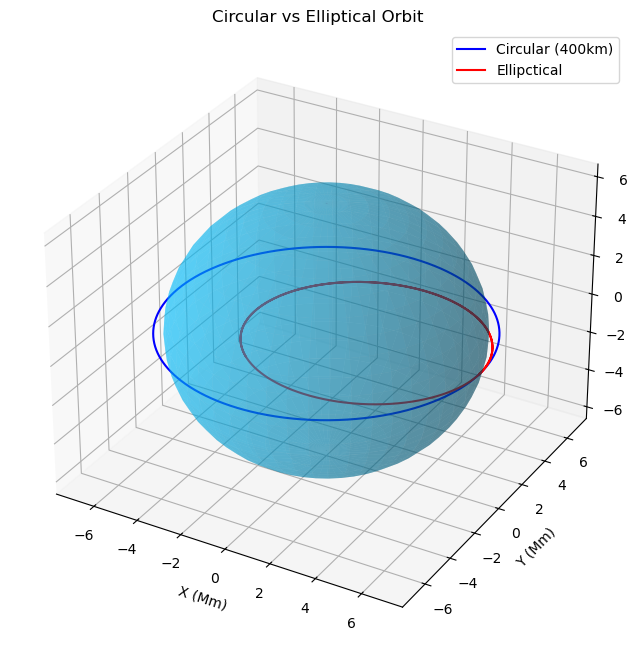

In [23]:
# Elliptical orbit - give it 80% of circular velocity
v_ellipse = 0.8 * v_circ

state0_ellipse = [r0, 0, 0, 0, v_ellipse, 0]

# Propagate for the same time span
solution_ellipse = solve_ivp(
    equations_of_motion, 
    t_span, 
    state0_ellipse, 
    t_eval=t_eval,
    method='RK45',
    rtol=1e-10,
    atol=1e-12
)

x_e = solution_ellipse.y[0]
y_e = solution_ellipse.y[1]
z_e = solution_ellipse.y[2]

# Plot both orbits together
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(x/1e6, y/1e6, 'b-', linewidth=1.5, label="Circular (400km)")
ax.plot(x_e/1e6, y_e/1e6, z_e/1e6, 'r-', linewidth=1.5, label='Ellipctical')

ax.plot_surface(ex, ey, ez, color='deepskyblue', alpha=0.4)

ax.set_xlabel('X (Mm)')
ax.set_ylabel('Y (Mm)')
ax.set_zlabel('Z (Mm)')
ax.set_title('Circular vs Elliptical Orbit')
ax.legend()

plt.tight_layout
plt.show()

In [24]:
def orbital_elements(state, GM=3.986004418e14):
    """
    Calculate classical orbital elements from a Cartesian state vector.
    state = [x, y, z, vx, vy, va]
    """ 

    x, y, z, vx, vy, vz = state

    r_vec = np.array([x,y, z])
    v_vec = np.array([vx, vy, vz])

    r = np.linalg.norm(r_vec)
    v = np.linalg.norm(v_vec)

    # Semi-major axis from the vis-viva equation
    a = 1 / (2/r - v**2/GM)

    # Eccentricity vector
    e_vec = (1/GM) * ((v**2 - GM/r) * r_vec - np.dot(r_vec, v_vec) * v_vec)
    e = np.linalg.norm(e_vec)

    #Inclination from angular momentum vector
    h_vec = np.cross(r_vec, v_vec)
    i = np.degrees(np.arccos(h_vec[2] / np.linalg.norm(h_vec)))

    return a, e, i

# Calculate elements for both orbits at t=0
a_circ, e_circ, i_circ = orbital_elements(state0)
a_ellipse, e_ellipse, i_ellipse = orbital_elements(state0_ellipse)

print("circular Orbit:")
print(f'    Semi-major axis: {a_circ/1e3:.2f} km')
print(f'    Eccentricity:    {e_circ:.6f}')
print(f'    Inclination:     {i_circ:.2f} degrees')

print('\nElliptical orbit:')
print(f'    Semi-major axis: {a_ellipse/1e3:.2f} km')
print(f'    Eccentricity:    {e_ellipse:.6f}')
print(f'    Inclination:     {i_ellipse:.2f} degrees')

circular Orbit:
    Semi-major axis: 6770.00 km
    Eccentricity:    0.000000
    Inclination:     0.00 degrees

Elliptical orbit:
    Semi-major axis: 4977.94 km
    Eccentricity:    0.360000
    Inclination:     0.00 degrees
